<h1>Time Series Forecasting Recurrent Neural Network (RNN) </h1>

This notebook aims to use deep learning to forecast the time series the "CLOSE" of the SNP 500 stock using the stock data from other industries. 

Libraries of interest: <b>
    
    TensorFlow
    Keras
    
</b>

In [1]:
# Download the following libraries if you do not have them:
# !pip install --upgrade tensorflow

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler

In [3]:
# Keras imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.backend import square, mean

In [4]:
df = pd.read_csv("data\output.csv")
df.head()

,Date,Open_Pharm,High_Pharm,Low_Pharm,Close_Pharm,Adj Close_Pharm,Volume_Pharm,Open_Semicon,High_Semicon,Low_Semicon,...,Low_Utilities,Close_Utilities,Adj Close_Utilities,Volume_Utilities,Open_Consumer,High_Consumer,Low_Consumer,Close_Consumer,Adj Close_Consumer,Volume_Consumer
0,4/1/2010,33.150002,33.544998,33.020000,33.535000,26.125103,1622800,28.350000,28.660000,28.299999,...,31.010000,31.080000,21.588554,8217600,29.900000,30.110001,29.900000,30.000000,25.967613,5443900
1,5/1/2010,33.580002,33.580002,33.134998,33.220001,25.879725,1933200,28.450001,28.540001,28.080000,...,30.559999,30.709999,21.331547,18023700,30.010000,30.139999,29.820000,30.110001,26.062828,6162200
2,6/1/2010,33.250000,33.384998,33.169998,33.384998,26.008247,1492400,28.209999,28.450001,28.080000,...,30.690001,30.889999,21.456575,12745100,30.090000,30.219999,30.020000,30.150000,26.097452,4246900
3,7/1/2010,33.285000,33.419998,33.230000,33.330002,25.965412,764600,28.090000,28.160000,27.760000,...,30.639999,30.750000,21.359331,6563100,30.340000,30.410000,30.139999,30.400000,26.313848,5736700
4,8/1/2010,33.259998,33.369999,33.185001,33.340000,25.973190,1218200,27.940001,28.549999,27.870001,...,30.520000,30.719999,21.338493,6267600,30.290001,30.410000,30.120001,30.389999,26.305195,6438000


In [5]:
df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)
indexeddf = df.set_index(['Date']) # Passed strings into a datetime format using to_datetime (inbuilt function in pandas)
from datetime import datetime
indexeddf.head(5) # Dates should be bold now and the word \"Date\" should be of a different row from the rest

,Open_Pharm,High_Pharm,Low_Pharm,Close_Pharm,Adj Close_Pharm,Volume_Pharm,Open_Semicon,High_Semicon,Low_Semicon,Close_Semicon,...,Low_Utilities,Close_Utilities,Adj Close_Utilities,Volume_Utilities,Open_Consumer,High_Consumer,Low_Consumer,Close_Consumer,Adj Close_Consumer,Volume_Consumer
Date,,,,,,,,,,,,,,,,,,,,,
2010-04-01,33.150002,33.544998,33.020000,33.535000,26.125103,1622800,28.350000,28.660000,28.299999,28.410000,...,31.010000,31.080000,21.588554,8217600,29.900000,30.110001,29.900000,30.000000,25.967613,5443900
2010-05-01,33.580002,33.580002,33.134998,33.220001,25.879725,1933200,28.450001,28.540001,28.080000,28.250000,...,30.559999,30.709999,21.331547,18023700,30.010000,30.139999,29.820000,30.110001,26.062828,6162200
2010-06-01,33.250000,33.384998,33.169998,33.384998,26.008247,1492400,28.209999,28.450001,28.080000,28.180000,...,30.690001,30.889999,21.456575,12745100,30.090000,30.219999,30.020000,30.150000,26.097452,4246900
2010-07-01,33.285000,33.419998,33.230000,33.330002,25.965412,764600,28.090000,28.160000,27.760000,27.959999,...,30.639999,30.750000,21.359331,6563100,30.340000,30.410000,30.139999,30.400000,26.313848,5736700
2010-08-01,33.259998,33.369999,33.185001,33.340000,25.973190,1218200,27.940001,28.549999,27.870001,28.520000,...,30.520000,30.719999,21.338493,6267600,30.290001,30.410000,30.120001,30.389999,26.305195,6438000


In [6]:
df.values.shape

(2571, 55)

Now we need to pinpoint the variable of interest as well as the shifting rate, which is the amount of days into the future we want to predict.

In [7]:
targets = ['Adj Close_SNP500', 'Close_SNP500']

In [8]:
shift_days = 1
shift_steps = 1 * 365 # Number of years

This is the new dataframe with the time-shifted data

In [9]:
df_targets = df[targets].shift(-shift_steps)

<h4>Ensure that the df has been successfully shifted:

In [10]:
df[targets].head(shift_steps + 5)

,Adj Close_SNP500,Close_SNP500
0,1132.989990,1132.989990
1,1136.520020,1136.520020
2,1137.140015,1137.140015
3,1141.689941,1141.689941
4,1144.979980,1144.979980
...,...,...
365,1265.420044,1265.420044
366,1267.640015,1267.640015
367,1271.500000,1271.500000
368,1278.359985,1278.359985


In [11]:
df_targets.head(5)

,Adj Close_SNP500,Close_SNP500
0,1265.420044,1265.420044
1,1267.640015,1267.640015
2,1271.500000,1271.500000
3,1278.359985,1278.359985
4,1295.520020,1295.520020


In [12]:
df_targets.tail()

,Adj Close_SNP500,Close_SNP500
2566,NaN,NaN
2567,NaN,NaN
2568,NaN,NaN
2569,NaN,NaN
2570,NaN,NaN


### NumPy Arrays

We now convert the Pandas data-frames to NumPy arrays that can be input to the neural network. We also remove the last part of the numpy arrays, because the target-data has `NaN` for the shifted period, and we only want to have valid data and we need the same array-shapes for the input- and output-data.

These are the input-signals:

In [13]:
# # We want to only include data from other industries and NOT SNP500, hence remove them.

df = df.drop(['Date'], axis = 1) 

In [14]:
dforiginal = pd.read_csv("data\output.csv") # Assigning the unedited one

In [15]:
x_data = df.values[0:-shift_steps]

In [16]:
print(type(x_data))
print("Shape:", x_data.shape)

<class 'numpy.ndarray'>
Shape: (2206, 54)


These are the output-signals (or target-signals):

In [17]:
y_data = df_targets.values[:-shift_steps]

In [18]:
print(type(y_data))
print("Shape:", y_data.shape)

<class 'numpy.ndarray'>
Shape: (2206, 2)


In [19]:
num_data = len(x_data) # No. of obs
train_split = 0.9 # Fraction of data used as training
num_train = int(num_data * train_split) # Number of obs used in training set
num_train

1985

In [20]:
num_test = num_data - num_train # Number of obs used for testing
num_test

221

In [21]:
x_train = x_data[0:num_train] # Assigning input signals
x_test = x_data[num_train:]
print('No. of input times: ' + str(len(x_train) + len(x_test)))

No. of input times: 2206


In [22]:
y_train = y_data[0:num_train] # Assigning output signals
y_test = y_data[num_train:]
print('No. of output times: ' + str(len(y_train) + len(y_test)))

No. of output times: 2206


In [23]:
num_x_signals = x_data.shape[1]
print('No of input signals: ' + str(num_x_signals))

No of input signals: 54


In [24]:
num_y_signals = y_data.shape[1]
print('No of output signals: ' + str(num_y_signals))

No of output signals: 2


### Scaling the Data

Look for the range of values in the data-set:

In [25]:
print("Min:", np.min(x_train))
print("Max:", np.max(x_train))

Min: 6.054201
Max: 10617810000.0


In [26]:
x_scaler = MinMaxScaler()

In [27]:
x_train_scaled = x_scaler.fit_transform(x_train)
print("Min:", np.min(x_train_scaled))
print("Max:", np.max(x_train_scaled))
x_test_scaled = x_scaler.transform(x_test)

Min: 0.0
Max: 1.0000000000000002


In [28]:
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)
print("Min:", np.min(y_train_scaled))
print("Max:", np.max(y_train_scaled))

Min: 0.0
Max: 1.0


## Data Generation

Instead of training the Recurrent Neural Network on the complete sequences of almost 300k observations, we will use the following function to create a batch of shorter sub-sequences picked at random from the training-data.

In [29]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

We will use a large batch-size so as to keep the GPU near 100% work-load. You may have to adjust this number depending on your GPU, its RAM and your choice of `sequence_length` below.

In [30]:
batch_size = 144

Use a sequence length of 365, which corresponds to 1 year

In [31]:
sequence_length = 365
sequence_length

365

In [32]:
generator = batch_generator(batch_size=batch_size,
                            sequence_length=sequence_length) # Creation of batch-generator

In [33]:
x_batch, y_batch = next(generator)

In [34]:
print(x_batch.shape)
print(y_batch.shape)

(144, 365, 54)
(144, 365, 2)


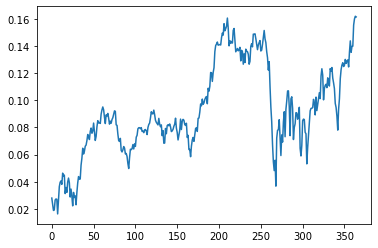

In [35]:
batch = 0   # First sequence in the batch.
signal = 0  # First signal from the 20 input-signals.
seq = x_batch[batch, :, signal]
plt.plot(seq)

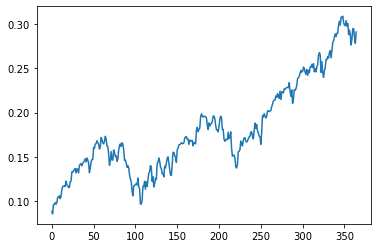

In [36]:
seq = y_batch[batch, :, signal]
plt.plot(seq)

### Validation Set

The neural network trains quickly so we can easily run many training epochs. But then there is a risk of overfitting the model to the training-set so it does not generalize well to unseen data. We will therefore monitor the model's performance on the test-set after each epoch and only save the model's weights if the performance is improved on the test-set.

The batch-generator randomly selects a batch of short sequences from the training-data and uses that during training. But for the validation-data we will instead run through the entire sequence from the test-set and measure the prediction accuracy on that entire sequence.

In [37]:
validation_data = (np.expand_dims(x_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))

## Create the Recurrent Neural Network

We are now ready to create the Recurrent Neural Network (RNN). We will use the Keras API for this because of its simplicity. 

In [38]:
model = Sequential()

We can now add a Gated Recurrent Unit (GRU) to the network. This will have 512 outputs for each time-step in the sequence.

Note that because this is the first layer in the model, Keras needs to know the shape of its input, which is a batch of sequences of arbitrary length (indicated by `None`), where each observation has a number of input-signals (`num_x_signals`).

In [39]:
model.add(GRU(units=512,
              return_sequences=True,
              input_shape=(None, num_x_signals,)))

The GRU outputs a batch of sequences of 512 values. We want to predict 3 output-signals, so we add a fully-connected (or dense) layer which maps 512 values down to only 3 values.

The output-signals in the data-set have been limited to be between 0 and 1 using a scaler-object. So we also limit the output of the neural network using the Sigmoid activation function, which squashes the output to be between 0 and 1.

In [40]:
model.add(Dense(num_y_signals, activation='sigmoid'))

### Loss Function

We will use Mean Squared Error (MSE) as the loss-function that will be minimized. This measures how closely the model's output matches the true output signals.

However, at the beginning of a sequence, the model has only seen input-signals for a few time-steps, so its generated output may be very inaccurate. Using the loss-value for the early time-steps may cause the model to distort its later output. We therefore give the model a "warmup-period" of 50 time-steps where we don't use its accuracy in the loss-function, in hope of improving the accuracy for later time-steps.

In [41]:
warmup_steps = 5

In [42]:
def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred,
    but ignore the beginning "warmup" part of the sequences.
    
    y_true is the desired output.
    y_pred is the model's output.
    """

    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]

    # Calculat the Mean Squared Error and use it as loss.
    mse = mean(square(y_true_slice - y_pred_slice))
    
    return mse

### Compile Model

This is the optimizer and the beginning learning-rate that we will use.

In [43]:
optimizer = RMSprop(lr=1e-3)
model.compile(loss=loss_mse_warmup, optimizer=optimizer)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, None, 512)         872448    
_________________________________________________________________
dense (Dense)                (None, None, 2)           1026      
Total params: 873,474
Trainable params: 873,474
Non-trainable params: 0
_________________________________________________________________


### Callback Functions

During training we want to save checkpoints and log the progress to TensorBoard so we create the appropriate callbacks for Keras.

This is the callback for writing checkpoints during training.

In [48]:
path_checkpoint = '23_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)
callback_tensorboard = TensorBoard(log_dir='./23_logs/',
                                   histogram_freq=0,
                                   write_graph=False,
                                  profile_batch = 100000000)
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

## Train the Recurrent Neural Network

We can now train the neural network.

Note that a single "epoch" does not correspond to a single processing of the training-set, because of how the batch-generator randomly selects sub-sequences from the training-set. Instead we have selected `steps_per_epoch` so that one "epoch" is processed in a few minutes.

With these settings, each "epoch" took about 2.5 minutes to process on a GTX 1070. After 14 "epochs" the optimization was stopped because the validation-loss had not decreased for 5 "epochs". This optimization took about 35 minutes to finish.

Also note that the loss sometimes becomes `NaN` (not-a-number). This is often resolved by restarting and running the Notebook again. But it may also be caused by your neural network architecture, learning-rate, batch-size, sequence-length, etc. in which case you may have to modify those settings.

In [49]:
%%time
model.fit(x=generator,
          epochs=20,
          steps_per_epoch=100,
          validation_data=validation_data,
          callbacks=callbacks)

  ...
    to  
  ['...']
Train for 100 steps, validate on 1 samples
Epoch 1/20
 99/100 [============================>.] - ETA: 4s - loss: 0.0085
Epoch 00001: val_loss improved from inf to 0.01693, saving model to 23_checkpoint.keras
100/100 [==============================] - 441s 4s/step - loss: 0.0085 - val_loss: 0.0169
Epoch 2/20
 99/100 [============================>.] - ETA: 5s - loss: 0.0035 
Epoch 00002: val_loss did not improve from 0.01693

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
100/100 [==============================] - 500s 5s/step - loss: 0.0035 - val_loss: 0.0237
Epoch 3/20
 99/100 [============================>.] - ETA: 5s - loss: 0.0011 
Epoch 00003: val_loss did not improve from 0.01693

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0001.
100/100 [==============================] - 518s 5s/step - loss: 0.0011 - val_loss: 0.0198
Epoch 4/20
 99/100 [============================>.] - ETA: 5s - loss: 8.0979e-04 
Epoch 000

KeyboardInterrupt: 